# DEPENDENCIES

In [1]:
import openseespy.opensees as ops
import matplotlib.pyplot as plt
import numpy as np


# MODEL CONSTRUCTION

## - INITIALIZATION

In [2]:
ops.wipe()  # Reset OpenSees model
ops.model('basic', '-ndm', 3, '-ndf', 3)  # 3D model with 3 DOF (X, Y, Z translations)

## - NODES CONSTRUCTION

### = Cnfiguration

In [3]:
# -Bridge dimensions
length_span = 10.0  # Length of one span (m)
width_bridge = 6.0  # Width of the bridge (m)
height_pier = 8.0  # Height of the bridge piers (m)
num_span = 4  # Number of spans

In [4]:
# <Helper Variables>
node_id = 1  # Index for node and its initial value
node_list = []  # List to store all nodes
node_deck = []  # List to store all nodes of the bridge deck
node_deck_left = []  # List to store left nodes of the bridge deck
node_deck_right = []  # List to store right nodes of the bridge deck
node_pier = []  # List to store all nodes of the bridge piers
node_pier_left = []  # List to store left nodes of the bridge piers
node_pier_right = []  # List to store right nodes of the bridge piers

### = Create Nodes for the bridge

In [5]:
# - Deck

# Loop over each span to create the nodes for the bridge deck
for i in range(num_span + 1):
    x = i * length_span  # X coordinate based on the span
    ops.node(node_id, x, 0.0, 0.0)  # Left node of the span
    ops.node(node_id + 1, x, width_bridge, 0.0)  # Right node of the span
    node_deck_left.append(node_id)
    node_deck_right.append(node_id + 1)
    node_deck.append(node_id)
    node_deck.append(node_id + 1)
    node_id += 2  # Move to the next

In [6]:
# - Piers

# Loop over each span to create the nodes for the bridge piers
for i in range(1, num_span):
    x = i * length_span  # X coordinate based on the span
    ops.node(node_id, x, 0.0, -height_pier)  # Left node of the span
    ops.node(node_id + 1, x, width_bridge, -height_pier)  # Right node of the span
    node_pier_left.append(node_id)
    node_pier_right.append(node_id + 1)
    node_pier.append(node_id)
    node_pier.append(node_id + 1)
    node_id += 2  # Move to the next

In [7]:
# - Nodes
node_list = node_deck + node_pier

## - MATERIAL CONSTRUCTION

### = Material Properties

In [8]:
# <Material Properties>
E = 12000  # Elastic modulus for timber (MPa)
A = 0.05   # Cross-sectional area (m^2)

### = Material Definition

In [9]:
# <Material Definition>
ops.uniaxialMaterial("Elastic", 1, E)

## - ELEMENT CONSTRUCTION

### = Helper Variables

In [10]:
# <Helper Variables>
element_id = 1  # Index for element and its initial value
element_list = []  # List to store all elements
element_deck = []  # List to store all elements of the bridge deck
element_pier = []  # List to store all elements of the bridge piers

### = Create Elements for the Bridge

In [11]:
# <Create Elements (Truss) for the Bridge>

# - Deck Truss Elements

# Loop over each span to create the elements for the bridge deck
for i in range(num_span):
    # Nodes
    left_near_node = node_deck_left[i]
    right_near_node = node_deck_right[i]
    left_far_node = node_deck_left[i + 1]
    right_far_node = node_deck_right[i + 1]
    
    # Y-direction truss elements
    if i == 0:
        ops.element("truss", element_id, left_near_node, right_near_node, A, 1)
        element_deck.append(element_id)
        element_id += 1
    ops.element("truss", element_id, left_far_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    
    # X-direction truss elements
    ops.element("truss", element_id, left_near_node, left_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_near_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    
    # Diagonal truss elements
    ops.element("truss", element_id, left_near_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1 
    ops.element("truss", element_id, left_far_node, right_near_node, A, 1)
    element_deck.append(element_id)
    element_id += 1

# - Pier Truss Elements

# Loop over each span to create the elements for the bridge piers
for i in range(num_span - 1):
    # Nodes
    left_high_node = node_deck_left[i + 1]
    right_high_node = node_deck_right[i + 1]
    left_low_node = node_pier_left[i]
    right_low_node = node_pier_right[i]
    
    # Z-direction truss elements
    ops.element("truss", element_id, left_high_node, left_low_node, A, 1)
    element_pier.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_high_node, right_low_node, A, 1)
    element_pier.append(element_id)
    element_id += 1
    
    # Diagonal truss elements
    ops.element("truss", element_id, left_high_node, right_low_node, A, 1)
    element_pier.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_high_node, left_low_node, A, 1)
    element_pier.append(element_id)
    element_id += 1

# - Elements
element_list = element_deck + element_pier

## - BOUNDARY CONDITIONS

In [12]:
# [BOUNDARY CONDITIONS]

# 1. Fix the leftmost and rightmost deck nodes in XYZ directions
ops.fix(node_deck_left[0], 1, 1, 1)  # Fix node at left end
ops.fix(node_deck_right[0], 1, 1, 1)  # Fix node at left end
ops.fix(node_deck_left[-1], 1, 1, 1)  # Fix node at right end
ops.fix(node_deck_right[-1], 1, 1, 1)  # Fix node at right end

# 2. Fix all the pier bottom nodes (both left and right)
for i in range(len(node_pier_left)):
    ops.fix(node_pier_left[i], 1, 1, 1)  # Fix left bottom pier nodes
    ops.fix(node_pier_right[i], 1, 1, 1)  # Fix right bottom pier nodes


## - MODEL VISUALIZATION

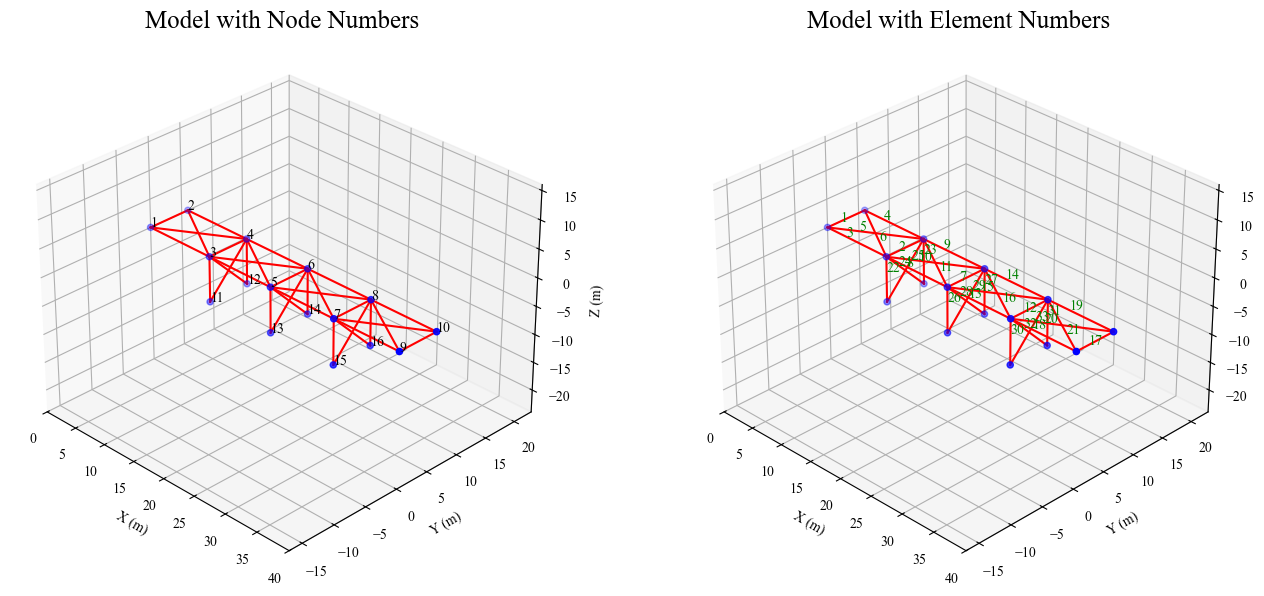

In [13]:
# Function to extract coordinates of nodes
def get_node_coords(node_ids):
    x_coords = [ops.nodeCoord(node_id)[0] for node_id in node_ids]
    y_coords = [ops.nodeCoord(node_id)[1] for node_id in node_ids]
    z_coords = [ops.nodeCoord(node_id)[2] for node_id in node_ids]
    return x_coords, y_coords, z_coords

# Setting Times New Roman font for the entire plot
plt.rcParams["font.family"] = "Times New Roman"

# Plotting the model with node numbers and element numbers
fig = plt.figure(figsize=(14, 6))

# Define axis limits to be uniform and "clean" (rounded values)
x_lim = [0, 40]  # Assuming the total length of the bridge spans
y_lim = [-1, 7]  # Setting y-range to be a bit wider to include bridge width
z_lim = [-10, 2]  # To cover the deck and piers' heights

# Set the viewing angle to be consistent for both plots
view_elev = 30  # Elevation angle
view_azim = -45  # Azimuth angle

# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range])

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

# Left plot: Model with node numbers
ax1 = fig.add_subplot(121, projection='3d')
x_coords, y_coords, z_coords = get_node_coords(node_list)
ax1.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Nodes')

# Add node labels
for node_id in node_list:
    x, y, z = ops.nodeCoord(node_id)
    ax1.text(x, y, z, f'{node_id}', fontsize=10, color='black')  # Node number

# Plot the elements (lines connecting nodes)
for elem_id in element_list:
    nodes = ops.eleNodes(elem_id)
    x_elem, y_elem, z_elem = get_node_coords(nodes)
    ax1.plot(x_elem, y_elem, z_elem, 'r-')  # Red lines for elements

# Set axis limits and the viewing angle
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_zlim(z_lim)
ax1.view_init(elev=view_elev, azim=view_azim)

# Set equal aspect ratio
set_axes_equal(ax1)

# Axis labels and title with increased font size for title
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Model with Node Numbers', fontsize=18)

# Right plot: Model with element numbers
ax2 = fig.add_subplot(122, projection='3d')

# Plot the nodes again
ax2.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Nodes')

# Add element labels at 1/3 length of each element
for elem_id in element_list:
    nodes = ops.eleNodes(elem_id)
    x_elem, y_elem, z_elem = get_node_coords(nodes)
    ax2.plot(x_elem, y_elem, z_elem, 'r-')  # Red lines for elements
    
    # Calculate the 1/3 position of each element for label
    third_x_elem = x_elem[0] + (x_elem[1] - x_elem[0]) * 0.33
    third_y_elem = y_elem[0] + (y_elem[1] - y_elem[0]) * 0.33
    third_z_elem = z_elem[0] + (z_elem[1] - z_elem[0]) * 0.33
    ax2.text(third_x_elem, third_y_elem, third_z_elem, f'{elem_id}', fontsize=10, color='green')  # Element number at 1/3 length

# Set axis limits and the viewing angle
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_zlim(z_lim)
ax2.view_init(elev=view_elev, azim=view_azim)

# Set equal aspect ratio
set_axes_equal(ax2)

# Axis labels and title with increased font size for title
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title('Model with Element Numbers', fontsize=18)

plt.tight_layout()
plt.show()

# LOAD APPLICATION

In [14]:
# Apply random white noise dynamic load to nodes 5
dt = 0.01  # Time step in seconds
time_steps = 1000  # Number of time steps
time = np.linspace(0, dt * time_steps, time_steps)

# Generate white noise excitation for nodes 3 and 8
white_noise = np.random.normal(0, 100, time_steps)  # White noise at node 5

# Apply white noise to node 3 (left side of the second span)
ops.timeSeries('Path', 1, '-dt', dt, '-values', *white_noise)
ops.pattern('Plain', 1, 1)
ops.load(5, 0.3, 0.05, 0.8)  # Apply white noise in Z direction


# ANALYSES & RECORDING

In [15]:
# Recorder for nodes 3 and 8 displacements
ops.recorder('Node', '-file', 'disp_node_3.txt', '-time', '-node', 3, '-dof', 1, 2, 3, 'disp')
ops.recorder('Node', '-file', 'disp_node_8.txt', '-time', '-node', 8, '-dof', 1, 2, 3, 'disp')

# Define analysis options
ops.algorithm('Newton')
ops.system('BandGeneral')
ops.numberer('Plain')
ops.constraints('Plain')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')

# Run analysis
ops.analyze(time_steps, dt)

0

# POST-PROCESSING

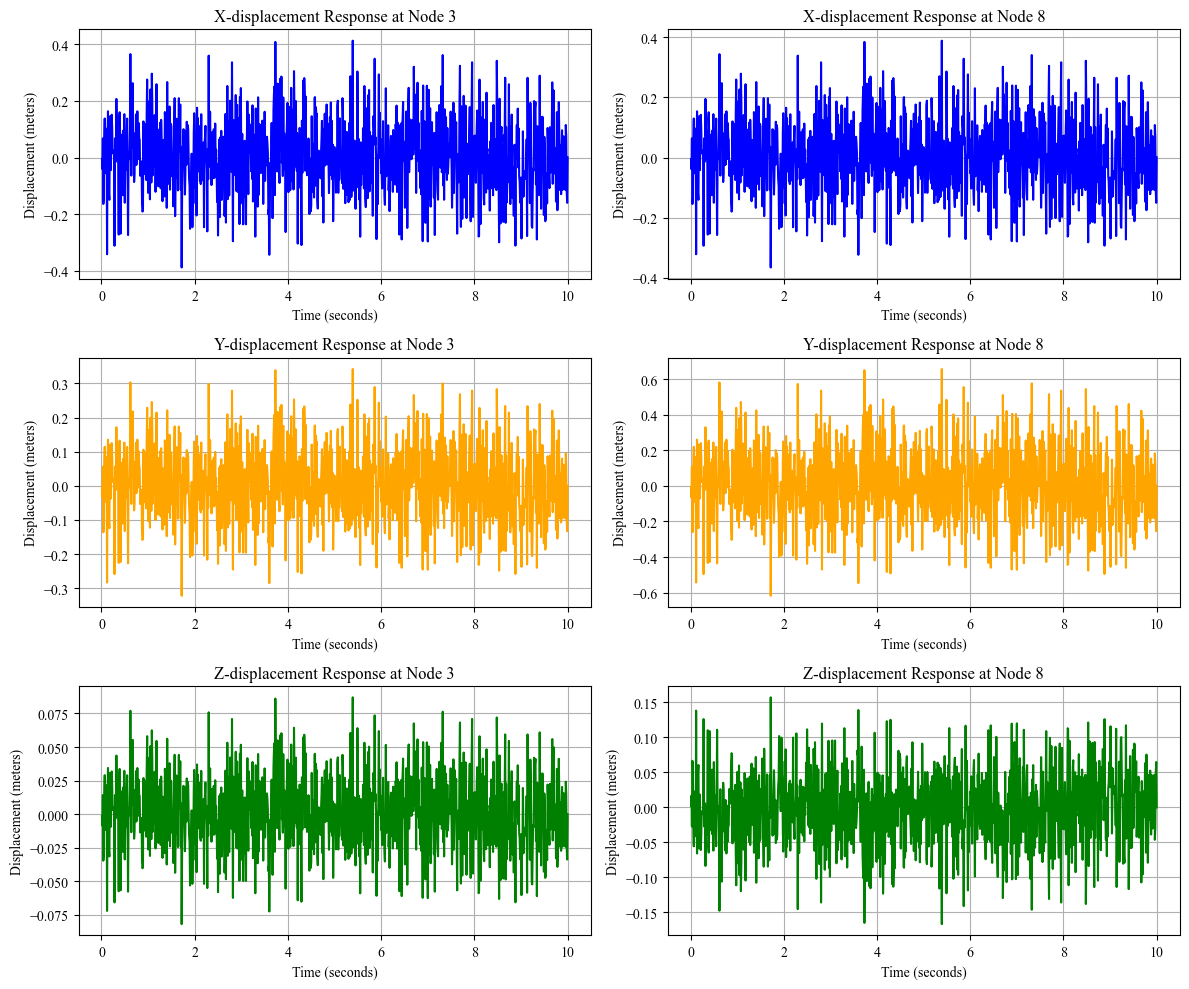

In [16]:
# Load the recorded displacements
disp_node_3 = np.loadtxt('disp_node_3.txt')
disp_node_8 = np.loadtxt('disp_node_8.txt')

# Create a figure for side-by-side comparison
plt.figure(figsize=(12, 10))

# Plot the X, Y, Z displacement results for node 3
plt.subplot(3, 2, 1)
plt.plot(disp_node_3[:, 0], disp_node_3[:, 1], label='Node 3 X-displacement', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('X-displacement Response at Node 3')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(disp_node_3[:, 0], disp_node_3[:, 2], label='Node 3 Y-displacement', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Y-displacement Response at Node 3')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(disp_node_3[:, 0], disp_node_3[:, 3], label='Node 3 Z-displacement', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Z-displacement Response at Node 3')
plt.grid(True)

# Plot the X, Y, Z displacement results for node 8
plt.subplot(3, 2, 2)
plt.plot(disp_node_8[:, 0], disp_node_8[:, 1], label='Node 8 X-displacement', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('X-displacement Response at Node 8')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(disp_node_8[:, 0], disp_node_8[:, 2], label='Node 8 Y-displacement', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Y-displacement Response at Node 8')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(disp_node_8[:, 0], disp_node_8[:, 3], label='Node 8 Z-displacement', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Z-displacement Response at Node 8')
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
ops.wipe()

In [18]:
# compare the maximum values of the displacements along x y z directions for two monitoring nodes

# X displacement comparison
max_disp_x_node_3 = np.max(np.abs(disp_node_3[:, 1]))
max_disp_x_node_8 = np.max(np.abs(disp_node_8[:, 1]))
print(f'Maximum X-displacement at Node 3: {max_disp_x_node_3:.4f} meters')
print(f'Maximum X-displacement at Node 8: {max_disp_x_node_8:.4f} meters')

# Y displacement comparison
max_disp_y_node_3 = np.max(np.abs(disp_node_3[:, 2]))
max_disp_y_node_8 = np.max(np.abs(disp_node_8[:, 2]))
print(f'Maximum Y-displacement at Node 3: {max_disp_y_node_3:.4f} meters')
print(f'Maximum Y-displacement at Node 8: {max_disp_y_node_8:.4f} meters')

# Z displacement comparison
max_disp_z_node_3 = np.max(np.abs(disp_node_3[:, 3]))
max_disp_z_node_8 = np.max(np.abs(disp_node_8[:, 3]))
print(f'Maximum Z-displacement at Node 3: {max_disp_z_node_3:.4f} meters')
print(f'Maximum Z-displacement at Node 8: {max_disp_z_node_8:.4f} meters')

Maximum X-displacement at Node 3: 0.4124 meters
Maximum X-displacement at Node 8: 0.3885 meters
Maximum Y-displacement at Node 3: 0.3425 meters
Maximum Y-displacement at Node 8: 0.6564 meters
Maximum Z-displacement at Node 3: 0.0870 meters
Maximum Z-displacement at Node 8: 0.1667 meters
